# Mapper applied to ensembles
Use entropy-based dissimilarity and seats or EG as filtration.

In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from functools import partial
import pandas
import networkx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr
import mapper
from scipy.spatial.distance import pdist, squareform

Mapper warning: Could not load the module “fastcluster”.
The module “scipy.cluster.hierarchy“ is used instead, but it will be slower.
The 'cmappertools' module could not be imported.
The 'cmappertools' module could not be imported.
Intrinsic metric is not available.
The 'cmappertools' module could not be imported.


In [2]:
graph = Graph.from_file("../mggg-states/IL-shapefiles/Chicago/Chicago_Precincts/Chicago_Precincts.shp")

city = gpd.read_file("../mggg-states/IL-shapefiles/Chicago/Chicago_Precincts/Chicago_Precincts.shp")

/Users/michellefeng/anaconda/envs/vrdi2019/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(410, 1381), (26, 410), (410, 717), (105, 169)}
  overlaps


In [3]:
city.head

<bound method NDFrame.head of      full_text  precinct    shape_area      shape_len  ward       TOTPOP  \
0        41027      27.0  3.090762e+08  139749.430317  41.0  2197.199822   
1        05025      25.0  2.569525e+07   35894.522176   5.0  1179.000035   
2        48041      41.0  1.248113e+06    4917.914119  48.0  2077.999953   
3        03024      24.0  5.716768e+06   12629.240176   3.0  1677.000001   
4        02045      45.0  4.762711e+05    2986.071131   2.0  1448.999997   
5        20029      29.0  4.269571e+06   10168.308279  20.0  1520.999990   
6        10013      13.0  2.027402e+08   70199.480252  10.0  1655.999998   
7        29021      21.0  1.940289e+06    5575.044341  29.0  2116.999958   
8        04011      11.0  3.127426e+06   11089.037796   4.0  2040.999957   
9        10001       1.0  5.626781e+06   10344.127078  10.0  1240.936850   
10       48031      31.0  1.093626e+06    4308.690572  48.0  2607.000133   
11       20013      13.0  4.722735e+06    8882.764063  20.

In [4]:
demos = ["TOTPOP", "HISP", "NH_WHITE", "NH_BLACK", "NH_ASIAN", "TOTV_G15", "EMAN_G15"]
bad_columns = [var for var in demos if city[var].dtype != "int"]

for column in bad_columns:
    city[column] = city[column].astype(int)
    
city = city[city["TOTPOP"]>0]

In [5]:
city["wper"] = city["NH_WHITE"]/city["TOTPOP"]
city["bper"] = city["NH_BLACK"]/city["TOTPOP"]
city["hper"] = city["HISP"]/city["TOTPOP"]
city["aper"] = city["NH_ASIAN"]/city["TOTPOP"]
city["eman_per"] = city["EMAN_G15"]/city["TOTV_G15"]

In [6]:
num_precincts = len(city)
demo_attrs = ["wper", "bper", "hper", "aper"]
demo_pt_cloud = np.zeros((num_precincts,len(demo_attrs)))

for i in range(len(demo_attrs)):
    demo_pt_cloud[:,i] = city[demo_attrs[i]].values

In [7]:
n_data = num_precincts #number of data point
distance_matrix = squareform(pdist(demo_pt_cloud,"minkowski", p=1)) #pairwise distances as a matrix
filter_values = city["eman_per"].values #filtration values of data
n_interval = 5 #number of intervals in cover
cluster_parameter = 0.15 #tunable

In [8]:
straightened_distance_matrix = []
for i in range(0, n_data):
    for j in range(i+1, n_data):
        straightened_distance_matrix.append(max(0,distance_matrix[i][j]))

Upper triangular distance matrix: 


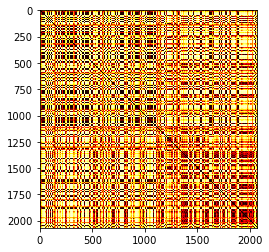

In [9]:
print("Upper triangular distance matrix: ")
plt.imshow(distance_matrix, cmap="hot")
plt.show()

In [10]:
covers = mapper.cover.cube_cover_primitive(intervals=n_interval)

Number of CPU cores present: 4
Start Mapper thread.Start Mapper thread.

Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [0.09, 0.89]
Mapper: Cover: Hypercube cover. Intervals: (5,). Overlap: (50.0,)
Mapper: Clustering: Single linkage clustering
Mapper: Cutoff: First gap of relative width 0.15
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Level: (4,)
Filter level (3,) has 550 points.Filter level (0,) has 365 points.

Filter level (2,) has 1500 points.
Filter level (1,) has 1417 points.
Filter level (4,) has 204 points.
There are 6 nodes.
Generate the simplicial complex.
Collect simplices of dimension 1:
There are 5 simplices of dimension 1.
Collect simplices of dimension 2:
There are 0 simplices of dimension 2.
Dimension: 1


Error: Could not call "neato". Make sure that graphviz is installed and that neato is in the search path.


FileNotFoundError: [Errno 2] No such file or directory: 'neato': 'neato'

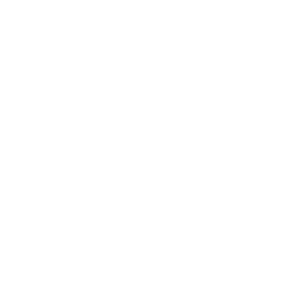

In [11]:
maps = mapper.mapper(np.array(distance_matrix), filter_values, covers, cutoff=mapper.cutoff.first_gap(cluster_parameter))
mapper.draw_mapper_output.draw_2D(maps, node_color_scheme=None)